# 과제 목표

1. 대규모 데이터로 미리 학습된 CLIP 모델로 이미지 혹은 텍스트의 CLIP feature를 추출하는 방법을 학습
2. CLIP 모델을 활용하여 비디오 속 프레임을 검색하는 기능을 구현

# 환경 세팅

본 실습에서 사용할 라이브러리를 import 하겠습니다. Colab을 사용할 경우, 아래 명령어로 CLIP을 추가 설치해주세요.

In [1]:
# Colab 사용 시
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-98w8wvff
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-98w8wvff
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fdb67d7c6dbd4f947f6171c033d5304d68114ca8a3d4a4a65562bdd37cbb1dc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_x4ppw93/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import math
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms.functional as F
import clip
import cv2
from PIL import Image
import matplotlib.pyplot as plt

Colab을 사용할 경우, 검색에 사용할 비디오를 자신의 구글 드라이브에 저장하고 이 비디오를 불러올 것입니다. 이를 위하여 구글 드라이브를 코랩 파일에 연결하겠습니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CLIP으로 영상 속 프레임 검색기 만들기

CLIP 활용의 실습으로, 비디오 내에서 내가 원하는 프레임을 검색해 보여주는 시스템을 만들어보겠습니다.

실습에 사용할 동영상은 자신이 원하는 것을 사용하면 됩니다. 손쉽게 영상을 얻을 수 있는 링크를 아래와 같이 첨부합니다.

- [Pexels](https://www.pexels.com/ko-kr/), [Pixabay](https://pixabay.com/): '동영상' 옵션 선택 후 원하는 영상을 검색
- [Artlist](https://artlist.io/stock-footage)
- [한국저작권위원회 공유마당](https://gongu.copyright.or.kr/gongu/wrt/wrtCl/listWrtVideo.do?menuNo=200026): 다양한 장면을 시험하기 위해 '영화' 카테고리 추천.

본 실습에 사용할 설정값을 지정합니다. 아래 `video_path`는 자신이 다운받은 비디오의 구글드라이브 링크로 바꾸고, `start_frame` 등 다른 설정값도 자신에 맞게 수정해주세요.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
video_path = 'drive/MyDrive/video.mp4' # colab path example: 'drive/MyDrive/project/sub2/video2.mp4'
start_frame = 0 # start of video frame extraction
end_frame = 0 # end of video frame extraction. 0 to end (max) of video frames
n_skip_frame = 0 # interval to extract frames in the video. 0 for all frames
batch_size = 256

본 실습에서는 huggingface에서 제공하는 CLIP 모델을 사용합니다. 사용 예시와 다양한 모델에 대한 docs는 아래 링크를 참조해주세요!

https://huggingface.co/docs/transformers/model_doc/clip

In [10]:
# CLIP 모델 및 이미지 프로세서 불러오기
model, preprocess = clip.load("ViT-B/32", device=device)

## 1. 검색에 사용할 비디오 불러오기

CLIP은 PIL 형태의 이미지를 입력으로 받아 처리합니다. load_video 함수를 구현하여 비디오에서 각 프레임을 받아올 수 있도록 합니다.

In [11]:
############################################################################
# Req 1-1: 검색에 사용할 비디오 불러오기                                        #
############################################################################

def load_video(video_path, start_frame, end_frame, n_skip_frame):
    """
    Args:
        video_path (str): path of video file
        start_frame, end_frame (int): start/end frame of video frame extraction
        n_skip_frame (int): interval to extract frames in the video. 0 for all frames
    Returns:
        frames (list[PIL.Image.Image]): list of video frames
        fps (int): FPS of video
    """
    ################################################################################
    # TODO: 비디오를 불러와 각 프레임을 PIL.Image 형태로 변경함                          #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) OpenCV의 VideoCapture를 이용하여 비디오를 열 수 있게 조치함
    # 2) start_frame부터 end_frame까지 n_skip_frame 간격으로 돌면서 각 프레임을 얻고, PIL Image로 변환함

    frames = [] # list[PIL.Image.Image]

    # OpenCV의 VideoCapture를 이용하여 비디오를 열 수 있게 조치함
    capture = cv2.VideoCapture(video_path)
    fps = capture.get(cv2.CAP_PROP_FPS) # FPS

    length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) # Number of frames
    end_frame = length if end_frame == 0 else end_frame
    n_skip_frame = 1 if n_skip_frame == 0 else n_skip_frame

    # start_frame부터 end_frame까지 n_skip_frame 간격으로 돌면서 각 프레임을 얻고, PIL Image로 변환함
    # 한 프레임은 (H, W, 3) 형상이며, 픽셀값이 [0, 255] 범위를 가짐.
    for i in range(start_frame, end_frame, n_skip_frame):
        # 해당 프레임으로 이동
        capture.set(cv2.CAP_PROP_POS_FRAMES, i)

        # 프레임 읽기
        ret, frame = capture.read()

        if not ret:
            break

        # OpenCV의 BGR 형식을 RGB 형식으로 변환
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 프레임을 PIL 이미지로 변환
        pil_image = Image.fromarray(frame)

        # 변환된 이미지를 프레임 리스트에 추가
        frames.append(pil_image)

    # 비디오 객체 해제
    capture.release()

    return frames, fps
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

아래 코드로 `load_video` 함수를 테스트할 수 있습니다.

In [12]:
frames, fps = load_video(video_path, start_frame, end_frame, n_skip_frame)
num_frame = len(frames)
print(f"Extracted Frames: {num_frame} ({(num_frame/fps):.2f} sec.)")

Extracted Frames: 263 (10.52 sec.)


## 2. 이미지의 CLIP feature 추출하기

각 프레임을 CLIP에 넣어 이미지 특징벡터를 추출하겠습니다.

사용자가 원하는 프레임의 텍스트 정보를 입력했을 때, 이미지 CLILP feature와 텍스트 CLIP feature 간의 유사도를 검사해 가장 높은 score를 가지는 프레임이 사용자가 원하는 프레임이라 할 수 있습니다.

In [13]:
############################################################################
# Req 1-2: 이미지의 CLIP feature 추출하기                                     #
############################################################################

def get_video_feat(model, preprocess, frames, batch_size, device):
    """
    Args:
        model (clip.model.CLIP): CLIP model
        preprocess (torchvision.transforms.transforms.Compose): preprocessing procedure of CLIP
        frames (list[PIL.Image.Image]): List of frames to get features
        batch_size (int): number of images to process within one batch
        device (str): device to run the model
    Returns:
        video_features (torch.Tensor): CLIP image features of input frames
    """
    ################################################################################
    # TODO: 각 비디오 프레임의 CLIP feature를 추출하고 normalize함                      #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 비디오 프레임을 배치 크기로 나눴을 때, 몇 개의 배치가 나오는지 계산하기
    num_batches = math.ceil(len(frames) / batch_size)

    # 비디오 피처를 저장할 리스트 초기화
    video_features = []

    # 2) 배치 개수만큼 아래 과정을 반복하며, feature를 저장하기
    for i in range(num_batches):
        # (1) 배치 크기 만큼의 프레임을 가져오기
        batch_frames = frames[i * batch_size:(i + 1) * batch_size]

        # (2) 이미지 전처리하기 & 텐서화 & device 지정하기
        batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)

        # (3) CLIP으로 이미지 피처 추출하기: encode_image() 함수 사용
        with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed)

        # (4) 위 결과를 normalize하기
        batch_features = batch_features / batch_features.norm(dim=-1, keepdim=True)

        # 배치 피처를 리스트에 추가
        video_features.append(batch_features)

    # 모든 배치 피처를 하나의 텐서로 결합
    video_features = torch.cat(video_features, dim=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    return video_features

아래 코드로 `get_video_feat` 함수를 테스트할 수 있습니다

In [14]:
video_features = get_video_feat(model, preprocess, frames, batch_size, device)
print(f"Shape of Features: {video_features.shape}") # [num_frame, dim=512]

Shape of Features: torch.Size([263, 512])


## 3. 텍스트-이미지 CLIP feature 간의 유사도 계산하기

입력한 텍스트에서 CLIP feature를 얻고, 이 feature와 비디오 각 프레임 image features 간의 유사도를 구하는 함수를 작성하겠습니다.

In [15]:
############################################################################
# Req 1-3: 텍스트-이미지 CLIP feature 간의 유사도 계산하기                      #
############################################################################

@torch.no_grad()
def similarity_score(search_query, video_features, device, k=5):
    """
    Args:
        search_query (str): Search query for video frame
        video_features (torch.Tensor): CLIP features of video. shape = [batch, dim_feature]
    Returns:
        sim_scores (torch.Tensor): Similarity scores of range [0, 1]. The length is same with the number of video frames
        topk_idx (torch.Tensor): Top k score indices. The length is k
    """
    ################################################################################
    # TODO: 사용자가 입력한 텍스트를 토크나이즈하여 CLIP 모델에 전달하여 text feature를 얻고 #
    # CLIP image featrues와의 유사도와 가장 높은 유사도의 K 개 인덱스를 추출함             #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 텍스트 입력을 토큰화: CLIP 모델의 tokenize 사용
    text_tokens = clip.tokenize([search_query]).to(device)

    # 2) Text CLIP feature 추출: encode_text 함수 사용
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # normalize

    # 3) 비디오 각 프레임과 텍스트 간 유사도 계산. torch.nn.CosineSimilarity 등을 이용할 수 있음.
    similarity = torch.matmul(video_features, text_features.T).squeeze(1)

    # 4) Softmax 함수를 사용하여 similarity score의 총합이 1이 되도록 함
    sim_scores = torch.nn.functional.softmax(similarity, dim=-1)

    # 5) 가장 유사도가 높은 k개의 점수와 프레임 인덱스를 구함
    topk_idx = sim_scores.topk(k, dim=-1).indices

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    return sim_scores, topk_idx

아래 코드로 `similarity_score` 함수를 테스트할 수 있습니다

In [16]:
similarity_scores, topk_idx = similarity_score(
    "a picture of a tiger", video_features, device, k=5,
)
print(f"Similarity scores: {max(similarity_scores):.5f} ~ {min(similarity_scores):.5f}")
print(f"Top-K indices: {topk_idx}")

Similarity scores: 0.00385 ~ 0.00377
Top-K indices: tensor([156, 157, 158, 160, 154], device='cuda:0')


## 4. 검색 결과 시각화

아래 함수는 텍스트 입력에 각 프레임이 얼마나 해당하는지(similarity score)를 입력으로 받아 그 정도를 시각화하는 함수입니다. Heatmap의 선이 붉을수록, 그래프의 y값이 높을수록 유사도가 높습니다.

In [17]:
def similarity_vis(similarities):

    similarities = similarities.cpu()

    fig, (ax1, ax2) = plt.subplots(nrows=2)
    ax1.imshow(
        similarities.unsqueeze(dim=0),
        cmap="magma",
        aspect="auto",
        extent=[0, len(similarities), 0, 1],
    )
    ax1.axes.yaxis.set_visible(False)
    ax2.plot(similarities)

    plt.show()
    plt.savefig("similarity_vis.jpg")

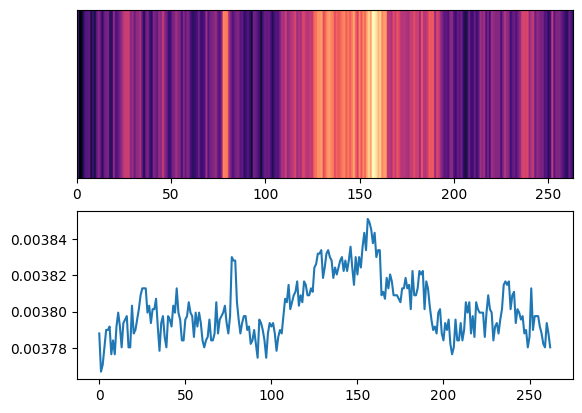

<Figure size 640x480 with 0 Axes>

In [18]:
similarity_vis(similarity_scores)

top-K 개의 가장 높은 유사도를 보이는 프레임을 조회할 수 있는 `visualize_images` 함수를 구현합니다.

In [21]:
############################################################################
# Req 1-4: 검색 결과 시각화                                                  #
############################################################################

def visualize_images(imgs):
    """
    Args:
        img (list[PIL.image]): List of images
    """
    ################################################################################
    # TODO: 이미지를 텐서화하고, 그리드를 이용하여 k 개의 이미지를 한 번에 나타냄            #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 이미지를 PyTorch Tensor로 변경
    imgs_tensor = torch.stack([F.to_tensor(img) for img in imgs])

    # 2) torchvision.utils.make_grid를 사용하여 그리드 안에 여러 이미지를 한 장에 담을 수 있게 함.
    # 한 행에 5개의 이미지를 담고, 이미지 간 간격은 2 픽셀로 설정
    grid_img = torchvision.utils.make_grid(imgs_tensor, nrow=5, padding=2)

    # 3) [C, H, W] 형태를 [H, W, C] 형태로 변경함.
    grid_img = grid_img.permute(1, 2, 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    plt.figure(figsize=(15,8))
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()
    plt.savefig("search_result_imgs.jpg")

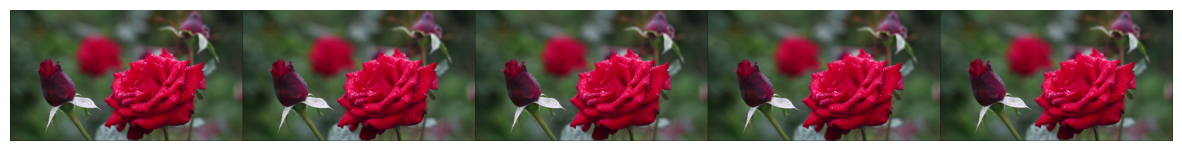

<Figure size 640x480 with 0 Axes>

In [22]:
topk_frames = [frames[idx] for idx in topk_idx]
visualize_images(topk_frames)